In [46]:
from time import time
from ipyparallel import Client
import numpy as np

In [47]:
def generate_stock_paths(s0, vol, steps, n_paths, r, dt):
    data_type = np.dtype('d') # double-precision floating point type
    S = np.zeros((steps + 1, n_paths), data_type)  # stock price matrix
    S[0, :] = s0  # intial values for stock price
    for t in range(1, steps + 1):
        levels = np.random.standard_normal(round(n_paths / 2))
        levels = np.concatenate((levels, -levels))  # antithetic variates
        levels = levels - np.mean(levels)  # normalize to have zero expectation
        levels = levels / np.std(levels)  # normalize standard deviation
        S[t, :] = S[t - 1, :] * np.exp((r - vol ** 2 / 2) * dt + vol * levels * np.sqrt(dt))
    return S


# LSM (least squares monte-carlo) valuation of american call options
#
# k     : strike
# S     : stock price paths matrix 
# steps : 
def american_call_value(S, k, df):
    steps = S.shape[0] - 1
    n_paths = S.shape[1]
    polynomial_degree = 5     # a constant for fitting the curve in LSM
    h = np.maximum(k - S, 0)  # intrinsic value of put option for each step
    V = np.zeros_like(h)      # value matrix
    C = np.zeros_like(h)         
    V[-1] = h[-1]
    for t in range(steps - 1, 0, -1):

        # fitting polynoms with least squares method
        # trying to fit the values of steps t+1 as a function of current stock price distribution
        regression = np.polyfit(S[t, :], V[t + 1, :] * df, polynomial_degree) 
        
        # the value of fitted curve given the current stock price 
        # is the LSM conditional estimate for option price
        C = np.polyval(regression, S[t, :])  
        
        # we apply exercise decistion as soon as the current payoff 
        # is greater than the expected conditional estimate
        V[t, :] = np.where(h[t, :] > C,
                           h[t, :], # exercise, i.e. record the payoff 
                           V[t + 1, :] * df) # wait for longer, i.e. record the estimate as discounted future payoff
    V0 = np.sum(V[1, :] * df) / n_paths  # LSM estimator
    return V0
                                       
# Parameters:
#  s0    : initial stock price
#  vol   : volatility of stock price
#  k     : strike
#  term  : time period (maturity), in days
#  steps : number of (price) steps for monte-carlo simulation
#  r     : interest rate
#  n_paths: number of paths to generate 
def option_value(s0, vol, term, k = 40, steps = 50, n_paths = 4096, r = 0.06):
    import numpy as np
    np.random.seed(314159) # fixing the seed to have repeatable results
    dt = term / steps  # small time increment
    df = np.exp(-r * dt)  # interest rate per time increment (discount factor)
    # simulation of stock price paths
    S = generate_stock_paths(s0, vol, steps, n_paths, r, dt)
    V0 = american_call_value(S, k, df)                                
    return V0, S


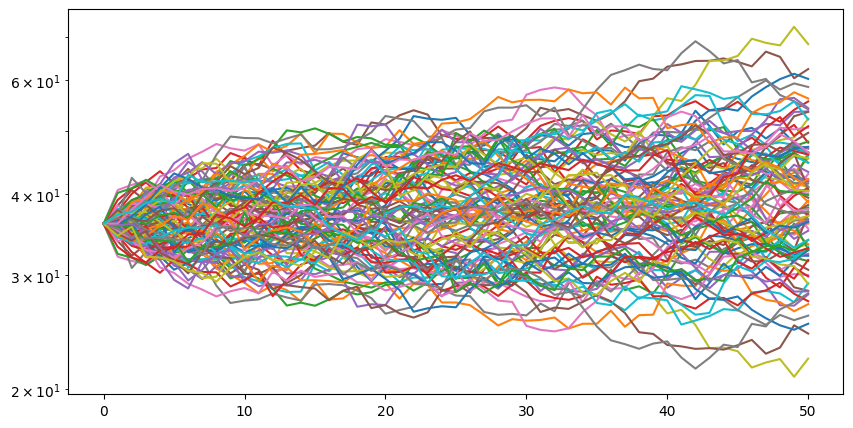

option price: 5.691128 


In [53]:
import matplotlib.pyplot as plt
from matplotlib import style 
S0 = 36
term = 2 # years
vol = 0.2
strike = 40
steps = 50
n_paths = 100
r = 0.06

v,S = option_value(S0, vol, term, strike, steps, n_paths, r)

fig = plt.figure(figsize=(10,5))
plt.yscale("log")
plt.plot(S)
plt.show()

print("option price: %f " % v)